# Learned Illumination Design for Fourier Ptychographic Microscopy

**author:** Michael Kellman

**overview:** In this notebook, illumination designs are learned to end to end optimize the Fourier Ptychographic microscope

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as ag
import time

import sys
sys.path.append('./source')
from fpm import *
from pytorch_complex import *
from utility import *
from recon import *

import sigpy.plot as pl

dtype = torch.float32
np_dtype = np.float32

mul_c  = ComplexMul().apply
div_c  = ComplexDiv().apply
abs_c = ComplexAbs().apply

# setup Graphical Processing Unit
gpu_device = 2
torch.cuda.set_device(gpu_device)
device = torch.device("cuda:"+str(gpu_device) if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(gpu_device)

_CudaDeviceProperties(name='TITAN X (Pascal)', major=6, minor=1, total_memory=12196MB, multi_processor_count=28)

In [2]:
# small problem for ICCP dataset (89 LEDS)
out_dir = '../Design_FPM_pytorch/datasets_train_iccp_results/'
filename = 'train_amp_exp_n10000.mat' 

dataset = FPMDataset(filename,out_dir)
specs = dataset.loadDataset()
locals().update(specs)
Np = [int(Np[0][0]), int(Np[0][1])]
ps = ps[0][0]
wl = wl[0][0]
mag = mag[0][0]
na = na[0][0]
na_illum = na_illum[0][0]
Nleds = Nleds[0][0]
z_offset = z_offset[0][0]
print(Np,ps,mag,wl,na,na_illum,Nleds,z_offset)
pruned_na_list = na_list[:Nleds,:]

(100, 35, 35, 2) (100, 89, 35, 35) (100, 89, 35, 35)
[35, 35] 6.5 4 0.514 0.2 0.42000000000000004 89 0


<IPython.core.display.Javascript object>


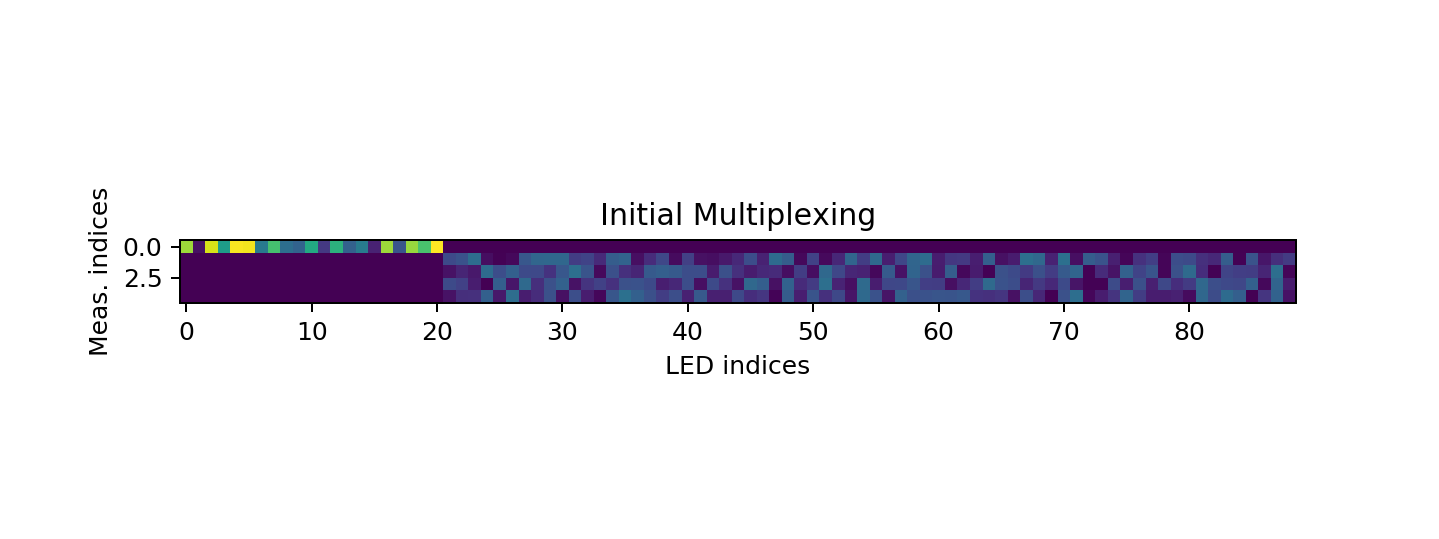

Text(0, 0.5, 'Meas. indices')

In [3]:
bands = [0,NbfLEDs,NdfLEDs]
csbands = np.cumsum(bands)
Nbands = len(bands)
NbandsMeas = [0,1,4]
Nmeas = np.sum(NbandsMeas)
Nrep = np.sum(bands)
Cinit = np.random.rand(Nmeas,Nrep).astype(np_dtype)

csNbandsMeas = np.cumsum(NbandsMeas)
Nmeas = np.sum(NbandsMeas)
bandMask2 = np.zeros((Nmeas,Nleds))
for ii in range(Nbands-1):
    bandMask2[csNbandsMeas[ii]:csNbandsMeas[ii+1],csbands[ii]:csbands[ii+1]] = 1

Cinit *= bandMask2

bandMask_torch = torch.from_numpy(bandMask2.astype(np_dtype))    
bandMask_torch = bandMask_torch.to(device)

for ii in range(Nmeas):
    Cinit[ii,:] /= np.sum(Cinit[ii,:]) + 1e-5

plt.figure(figsize=(8,3))
plt.imshow(Cinit)
plt.title('Initial Multiplexing')
plt.xlabel('LED indices')
plt.ylabel('Meas. indices')

In [4]:
# setup data example
data_idx = 2
measurements,truth = dataset[data_idx]
measurements = measurements.to(device)
truth = truth.to(device)

# setup model
grad = FPM(Np, na, na_illum, pruned_na_list, wl, ps, mag, 
            alpha = 5e-1, maxIter = 0, C_init=Cinit, measurements=measurements, testFlag=True, T=8, device=device)
grad.to(device)

# setup reconstruction
N_iter = 75
gd_layer = GD(grad)
recon = genNetwork(gd_layer,N_iter)
recon = recon.to(device)

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625


## Setup Learning

In [5]:
# setup initialization
loss = lambda x : torch.sum((x-truth)**2)

learning_iter = 100
learning_rate = 1e-1

psnrLearn = torch.zeros(learning_iter)
lossLearn = torch.zeros(learning_iter)
CLearn = torch.zeros(learning_iter,Cinit.shape[0],Cinit.shape[1])

## Learned design training

In [6]:
for liter in range(learning_iter):
    # zero gradients
    for p_ in recon.parameters(): p_.grad = None
    
    
    x0 = torch.zeros(measurements.shape[1],measurements.shape[2],2)
    x0[:,:,0] = measurements[0,:,:]
    x0 = x0.to(device)

    xN,X = feedforward(recon,x0,interFlag = False,testFlag = False,device=device)
    l = loss(xN)
    l.backward()
    
        
    with torch.no_grad():
        lossLearn[liter] = l.detach().cpu()
        psnrLearn[liter] = PSNR(recon=getAbs(xN),clean=getAbs(truth)).cpu()
        print('Iter:', liter, 'Loss:', lossLearn[liter].numpy(), 'PSNR:', psnrLearn[liter].numpy(), end="\r")     
        
        # gradient step
        grad.C.data -= learning_rate * grad.C.grad.data

        # Non-negativity constraint!
        grad.C.data = grad.C.data * (grad.C.data > 0).float()

        # mask constraint!
        grad.C.data *= bandMask_torch

        # scaling constraint!
        for ll in range(grad.C.shape[0]):
            grad.C[ll,:] /= torch.sum(grad.C[ll,:]) + 1e-10
        
        # storage (debug)
        CLearn[liter,...] = grad.C.detach().cpu()

<IPython.core.display.Javascript object>


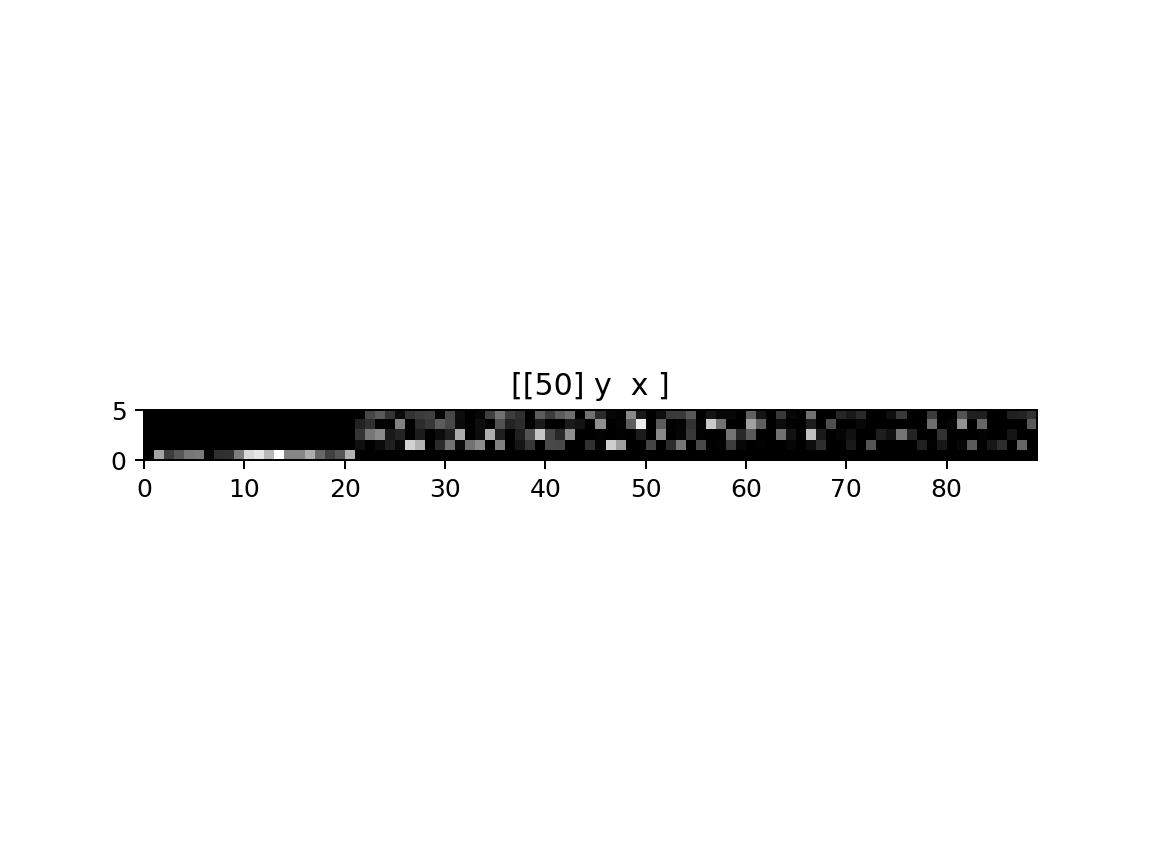

In [7]:
pl.ImagePlot(CLearn.cpu().numpy(),interpolation=None)

<IPython.core.display.Javascript object>


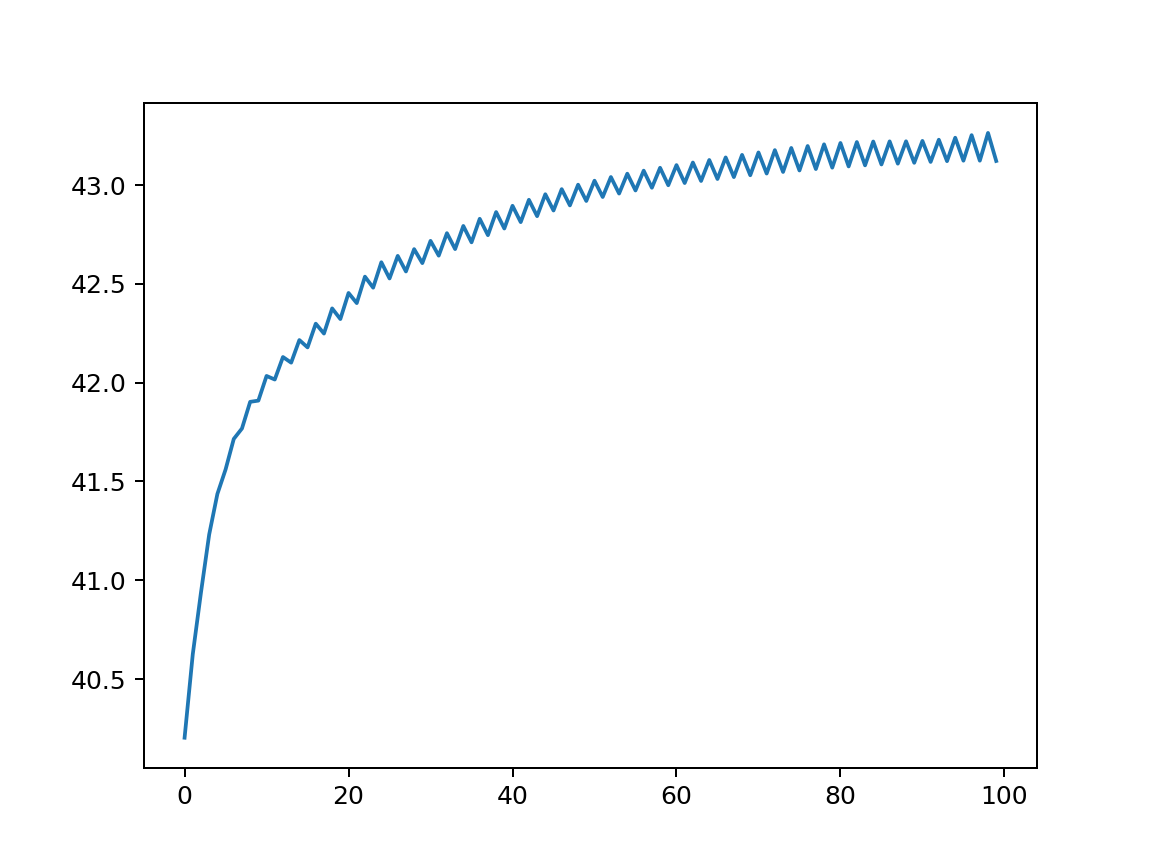

In [8]:
plt.figure()
plt.plot(psnrLearn.numpy())